# Melio Fullstack Data Scientist Technical Interview

### Task 1: Building the classifier

This is the main data science component of the technical assessment.

Build a classifier to determine whether the name belongs to a `Person`, `Company`, or `University`:

  - You can use any library you want.
  - You can use a rule-based classification, a pre-built model/embedding, build a model yourself or a hybrid.
  - Format:
    - If you are building an ML solution, the training of your model can be in a Jupyter notebook.
    - If you are not building an ML solution, you will have to embed your python code into the app.

Note that the classifications are generated by the client's upstream system, but it is not always correct.

## Submission Requirements

  1. Give enough information on how to run your solution (i.e. python version, packages, requirements.txt, Dockerfile, etc.).
  2. State all of your assumptions, if any.
  3. There is no right or wrong answer, but give a clear reasoning on each step you took.


In [1]:
import pandas as pd


try:
    df = pd.read_csv('names_data_candidate.csv')
    print("data read into dataframe")
except Exception as e:
    print(f"erorr: {e}")

data read into dataframe


## Exploratory Data Analysis

In [2]:
print(f"shape of data: {df.shape} \n\n sample of 10: \n\n {df.sample(10)}")

shape of data: (4520, 2) 

 sample of 10: 

                          dirty_name dirty_label
1331                  Sybila Moneti      Person
2482                     LANCE CUER      Person
4361                 FAYINA BURKETT      Person
3190                     Eléa Bigly     Company
1051                     peter horn      Person
1724                  Deborah Twala      Person
455        Mr ms. bronwyn laubscher      Person
1763                  Amelia Biford      Person
2528             Lucita Skentelbery      Person
2856  Photobean  KAYVEO Yakitri Pty     Company


In [3]:
# simple data info

print(f"Describe data: \n\n {df.describe()} \n\n")
print(df.info())


Describe data: 

                                    dirty_name dirty_label
count                                    4520        4520
unique                                   4519           3
top     Universidad Católica Anselmo Llorente      Person
freq                                        2        3690 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4520 entries, 0 to 4519
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dirty_name   4520 non-null   object
 1   dirty_label  4520 non-null   object
dtypes: object(2)
memory usage: 70.8+ KB
None



 Label counts 

 dirty_label
Person        3690
Company        732
University      98
Name: count, dtype: int64 

 Label percentagae 

 dirty_label
Person        81.637168
Company       16.194690
University     2.168142
Name: count, dtype: float64


<Axes: xlabel='dirty_label'>

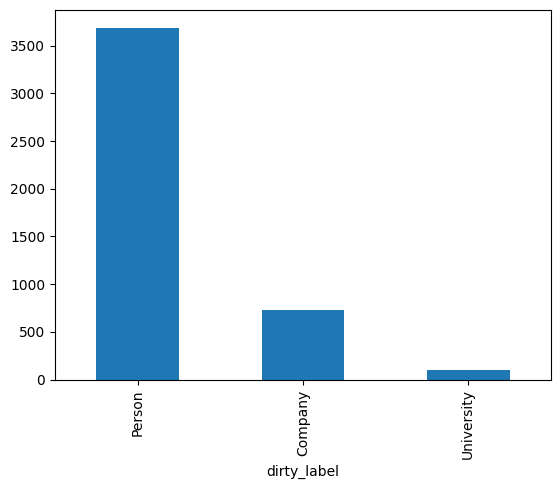

In [4]:
# Class counts and class balances
from matplotlib.pyplot import plot as plt

label_counts = df['dirty_label'].value_counts() # count total of each class
print(f"\n Label counts \n\n {label_counts} \n\n Label percentagae \n\n {(label_counts/4520)*100}")
label_counts.plot(kind='bar')


### In this current dataset there appears to be an imabance of classes, University only accounts for about 2% of the data while Person is about 81%

## Observations from EDA

    - 2 columns with unprocessed data
        - Dirty name: the given name
            - One duplicate
            - No null values
            - Dirty
                - non-ASCII char present
                - Some names are capitalized
                - Additional whitespaces
                - Special char present
    
        - Dirty label: the classification of the name
            - 3 unique classes: Person, Company, and University
            - no null values
            - from label/class plot and label counts:
                There is an imbalance; University names are only 2% of the dataset and Person is about 81%
                
        - Patterns in data
            - Person names noticed patterns; Titles like Mr, Miss, Prof, etc.
            - University has the word university in it
            - Company contain prefixes and suffixes like ldt, Pty, etc.
    

## Data Cleaning
### Normalize while cleaning the data
1. For consistancy and accuracy, remove punctuation,
2. Convert to only ASCII char, accounts for accents or pronounciation of the same word
3. remove unnecessary whitespaces and special chars


In [6]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.1 MB/s eta 0:00:00


In [8]:
import re
import unidecode

def clean_name(name):
    name = name.lower() # convert name to lowercase
    name = unidecode.unidecode(name) # convert to string with only ASCII chars
    name = re.sub(r'[^\w\s]', '', name)  # remove punctuation
    name = re.sub(r'\s+', ' ', name).strip()  # remove extra spaces
    return name

In [9]:
# Clean names in dataset
df['clean_name'] = df['dirty_name'].apply(clean_name)

print("Sample cleaned names:")
print(df['clean_name'].sample(5))

Sample cleaned names:
1992          charil dismore
2502       sr lorene iorizzo
1500          godwin swinden
2622           danni robelow
3458    mrs celeste conradie
Name: clean_name, dtype: object


### Check and remove duplicates


In [10]:
# Check duplicate and remove dupicates
print(df[df.duplicated()])
# Remove the duplicates
df.drop_duplicates(inplace = True)
print(df[df.duplicated()])
print("duplicates removed")
df.value_counts()

                                 dirty_name dirty_label  \
1457  Universidad Católica Anselmo Llorente  University   

                                 clean_name  
1457  universidad catolica anselmo llorente  
Empty DataFrame
Columns: [dirty_name, dirty_label, clean_name]
Index: []
duplicates removed


,,,count
dirty_name,dirty_label,clean_name,
åslög starbucke,Person,aslog starbucke,1
A AND R DEVELOPMENT SUPPLIES(PTY) LTD,Company,a and r development suppliespty ltd,1
A SCHOEMAN AND ASSOCIATES CC,Company,a schoeman and associates cc,1
ABBY GOOZEE,Person,abby goozee,1
ABRA YEGOROV,Company,abra yegorov,1
...,...,...,...
AGILIS INTERNATIONAL PTY LTD,Person,agilis international pty ltd,1
AGACE BERROW,Person,agace berrow,1
ADÉLAÏDE ROKE,Person,adelaide roke,1


## Feature Engineering

### TF-IDF Vectorization
    
### Features


In [15]:
## TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(ngram_range=(1,2),max_features=1000) # Initialize the vectorizer
X = v.fit_transform(df['clean_name']) # vector tranform the clean names
v.fit(df['clean_name'])
y = df['dirty_label']


print(f"Shape of TF-IDF matrix: {X.shape}")
print(f"Sample feature names: {v.get_feature_names_out()[:20]}")

Shape of TF-IDF matrix: (4519, 1000)
Sample feature names: ['abigail' 'abraham' 'abrahams' 'adam' 'adele' 'adriaan' 'africa'
 'africa pty' 'african' 'ahmed' 'alberts' 'alex' 'alexander' 'alfred'
 'alicia' 'alison' 'allan' 'allie' 'ally' 'am']


## Train-Test Split
### Stratify classes/labels; there is an imbalance

In [16]:
## Train test split
## Stratify the classes/labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, random_state=1
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3615, 1000)
Test shape: (904, 1000)


## Train model

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # TODO: Set class weight in model
model.fit(X_train, y_train)

print("Model trained")


Model trained


In [19]:
# view learned weights
import numpy as np

feature_names = v.get_feature_names_out()
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(model.coef_[i])[-10:]

    for counter,top in enumerate(top10[::-1]):

        print(f"Top {counter+1} words for {class_label}: {feature_names[top]}")

    print("\n\n\n")


Top 1 words for Company: pl
Top 2 words for Company: ltd
Top 3 words for Company: cc
Top 4 words for Company: co
Top 5 words for Company: pty
Top 6 words for Company: limited
Top 7 words for Company: corp
Top 8 words for Company: lp
Top 9 words for Company: consortium
Top 10 words for Company: inc




Top 1 words for Person: dr
Top 2 words for Person: miss
Top 3 words for Person: hon
Top 4 words for Person: ms
Top 5 words for Person: mrs
Top 6 words for Person: sr
Top 7 words for Person: du
Top 8 words for Person: mr
Top 9 words for Person: peter
Top 10 words for Person: le




Top 1 words for University: university
Top 2 words for University: universidad
Top 3 words for University: college
Top 4 words for University: of
Top 5 words for University: de
Top 6 words for University: instituto
Top 7 words for University: technological
Top 8 words for University: university of
Top 9 words for University: state
Top 10 words for University: technological university






## Predition, classification, confusion, and accuracy reporting

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print(y_pred[:10])
print(y_test[:10])


Classification Report:

              precision    recall  f1-score   support

     Company       0.94      0.58      0.72       147
      Person       0.92      0.99      0.95       738
  University       1.00      0.74      0.85        19

    accuracy                           0.92       904
   macro avg       0.95      0.77      0.84       904
weighted avg       0.92      0.92      0.91       904

['Person' 'Person' 'Person' 'Person' 'Person' 'Person' 'Person' 'Person'
 'Company' 'Person']
4364     Person
3643     Person
3496    Company
3738     Person
591      Person
211      Person
3090     Person
2028     Person
2417     Person
2800     Person
Name: dirty_label, dtype: object


Confusion Matrix:



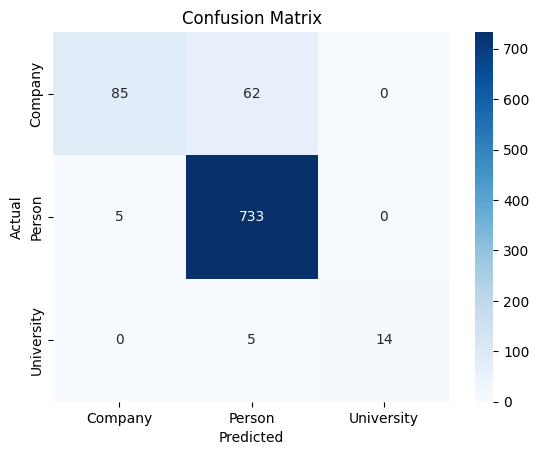

In [21]:
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 92.04%


## model and vector dumping

In [25]:
import joblib
import pickle
try:
    joblib.dump(model, 'model_v1.joblib')
    joblib.dump(v, 'vectorizer_v1.joblib')
    print("model and vectorizer saved")
except Exception as e:
    print(f"Error dumping model and vectorizer: {e}")




model and vectorizer saved
